# Libraries

In [29]:
import numpy as np
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score

In [7]:
# Data
np.random.seed(42)
data = np.random.rand(100, 5) 


In [8]:
# Convert data to tensor PyTorch
data_tensor = torch.tensor(data, dtype=torch.float32)

In [22]:
#Define the layer Self-Attention

class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.input_dim)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights


In [23]:
# Call self attention
attention_layer = SelfAttention(input_dim=data_tensor.shape[1])
attention_output, attention_weights = attention_layer(data_tensor)
attention_output_np = attention_output.detach().numpy()

In [24]:
# Use K/means to the output
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(attention_output_np)

/Users/kevinpalominopacheco/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


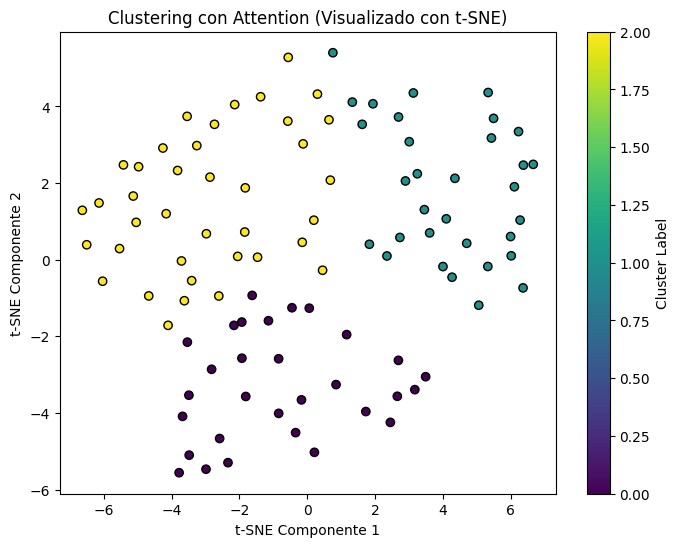

In [25]:
# Visualization
tsne = TSNE(n_components=2, random_state=42)
data_2d_tsne = tsne.fit_transform(attention_output_np)

plt.figure(figsize=(8, 6))
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('Clustering con Attention (Visualizado con t-SNE)')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [26]:
# 6. Feature importance
feature_importance = attention_weights.mean(dim=0).mean(dim=0)
print("Importancia de características:", feature_importance)

Importancia de características: tensor(0.0100, grad_fn=<MeanBackward1>)


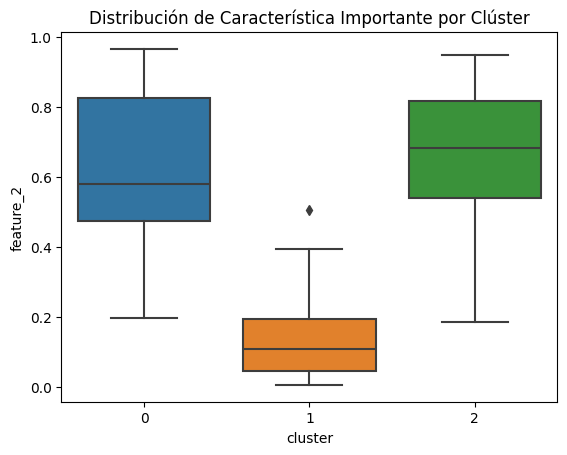

In [28]:
# 7. Feature importance visualization
df = pd.DataFrame(data, columns=[f'feature_{i}' for i in range(data.shape[1])])
df['cluster'] = labels
sns.boxplot(x='cluster', y='feature_2', data=df)  
plt.title('Feature importante by Clúster')
plt.show()

In [30]:
silhouette_avg = silhouette_score(attention_output_np, labels)
print("Silhouette metric:", silhouette_avg)

Puntuación promedio de Silueta: 0.31872705


In [31]:
sample_silhouette_values = silhouette_samples(attention_output_np, labels)


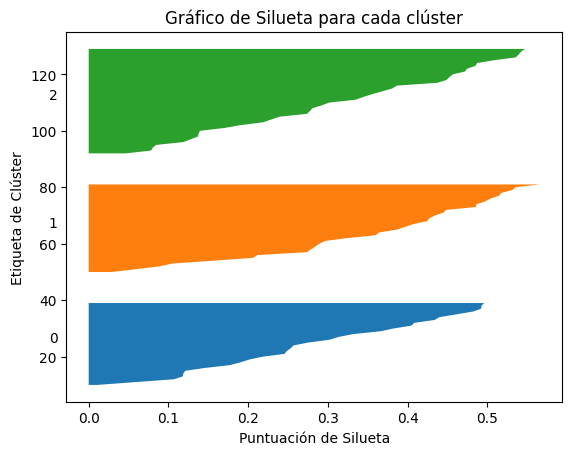

In [32]:
y_lower = 10
for i in range(3):  # Asumiendo 3 clústeres
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort() 

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples gap

plt.title("Gráfico de Silueta para cada clúster")
plt.xlabel("Puntuación de Silueta")
plt.ylabel("Etiqueta de Clúster")
plt.show()

In [33]:
cluster_centers = kmeans.cluster_centers_
closest_data_points = []

for i in range(3):  # Asumiendo 3 clústeres
    cluster_points = attention_output_np[labels == i]
    center = cluster_centers[i]
    distances = np.linalg.norm(cluster_points - center, axis=1)
    closest_data_points.append(cluster_points[np.argmin(distances)])

print("Prototipos de clústeres:", closest_data_points)

Prototipos de clústeres: [array([-0.4852329 ,  0.12978135,  0.7969959 , -0.5567926 ,  0.13280746],
      dtype=float32), array([-0.48749828,  0.12557246,  0.79853743, -0.5572391 ,  0.133029  ],
      dtype=float32), array([-0.48742637,  0.12882024,  0.79998314, -0.5581199 ,  0.13016883],
      dtype=float32)]


# Part 2


In [38]:

# 1. Definir la capa de Self-Attention
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(Q.shape[-1])
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

# 2. Sintetic data
np.random.seed(42)
data = np.random.rand(100, 10)  
data_tensor = torch.tensor(data, dtype=torch.float32)

# 3. Apply Self-Attention layer
attention_layer = SelfAttention(input_dim=data_tensor.shape[1])
attention_output, attention_weights = attention_layer(data_tensor)
attention_output_np = attention_output.detach().numpy()

# 4. Apply k-means clustering to the Self-Attention layer
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(attention_output_np)

# 5. Silhouette metric
silhouette_avg = silhouette_score(attention_output_np, cluster_labels)
print(f"Puntuación promedio de Silueta: {silhouette_avg}")

# 6. Integrar la salida del clustering en el proceso de aprendizaje (ejemplo simple)
# Aquí podrías usar los clústeres como parte de la función de pérdida o para ajustar los pesos
class AttentionClusteringModel(nn.Module):
    def __init__(self, input_dim, num_clusters):
        super(AttentionClusteringModel, self).__init__()
        self.attention = SelfAttention(input_dim)
        self.fc = nn.Linear(input_dim, num_clusters)  # Salida de clúster

    def forward(self, x):
        attention_output, _ = self.attention(x)
        cluster_logits = self.fc(attention_output)
        return cluster_logits

# 7. Entrenar el modelo con una función de pérdida que incorpore clústeres
model = AttentionClusteringModel(input_dim=data_tensor.shape[1], num_clusters=3)
criterion = nn.CrossEntropyLoss()  # Por ejemplo, puedes usar una función de pérdida supervisada
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Ejemplo simple de entrenamiento
for epoch in range(1000):
    optimizer.zero_grad()
    cluster_logits = model(data_tensor)
    loss = criterion(cluster_logits, torch.tensor(cluster_labels, dtype=torch.long))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

/Users/kevinpalominopacheco/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Puntuación promedio de Silueta: 0.2339245080947876
Epoch [10/100], Loss: 1.0870
Epoch [20/100], Loss: 1.0789
Epoch [30/100], Loss: 1.0292
Epoch [40/100], Loss: 0.8357
Epoch [50/100], Loss: 0.5755
Epoch [60/100], Loss: 0.3682
Epoch [70/100], Loss: 0.2079
Epoch [80/100], Loss: 0.1322
Epoch [90/100], Loss: 0.0975
Epoch [100/100], Loss: 0.0742
Epoch [110/100], Loss: 0.0585
Epoch [120/100], Loss: 0.0455
Epoch [130/100], Loss: 0.0358
Epoch [140/100], Loss: 0.0282
Epoch [150/100], Loss: 0.0226
Epoch [160/100], Loss: 0.0184
Epoch [170/100], Loss: 0.0152
Epoch [180/100], Loss: 0.0127
Epoch [190/100], Loss: 0.0106
Epoch [200/100], Loss: 0.0089
Epoch [210/100], Loss: 0.0075
Epoch [220/100], Loss: 0.0064
Epoch [230/100], Loss: 0.0054
Epoch [240/100], Loss: 0.0046
Epoch [250/100], Loss: 0.0039
Epoch [260/100], Loss: 0.0033
Epoch [270/100], Loss: 0.0028
Epoch [280/100], Loss: 0.0025
Epoch [290/100], Loss: 0.0021
Epoch [300/100], Loss: 0.0019
Epoch [310/100], Loss: 0.0016
Epoch [320/100], Loss: 0.001

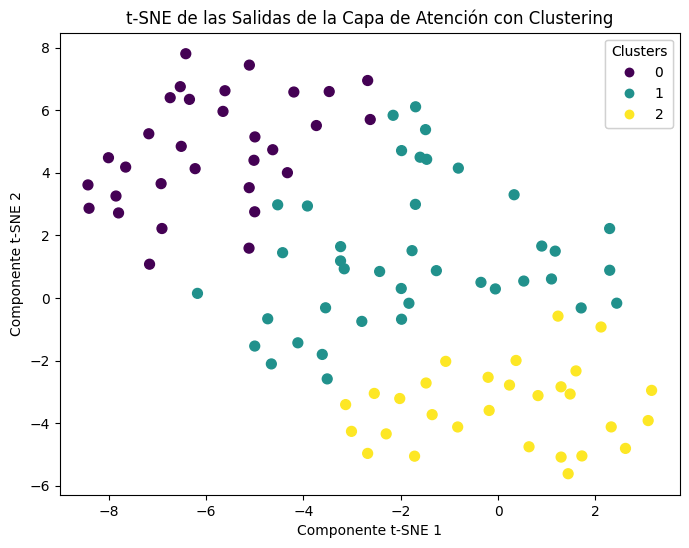

In [39]:
# Aplicar t-SNE para reducir la dimensionalidad de las salidas de la atención
tsne = TSNE(n_components=2, random_state=42)
attention_tsne = tsne.fit_transform(attention_output_np)

# Graficar los clústeres
plt.figure(figsize=(8, 6))
scatter = plt.scatter(attention_tsne[:, 0], attention_tsne[:, 1], c=cluster_labels, cmap='viridis', s=50)

# Añadir la leyenda
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)

# Añadir etiquetas y título
plt.title('t-SNE de las Salidas de la Capa de Atención con Clustering')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.show()